In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense , LSTM ,Dropout ,SpatialDropout1D
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from keras.callbacks import EarlyStopping ,  ModelCheckpoint
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('final_processed_df.csv').drop(columns=['Unnamed: 0'])
df

,Final_Text,Category
0,work picasso others stolen spain picasso art s...,Art
1,salwa maged art corner gallery exhibiting pain...,Art
2,tribute abdalla gohar 1 december khan al maghr...,Art
3,raw untamed compelling âfleshâ samir fouad...,Art
4,water mosaic gezira centre modern art exhibit ...,Art
...,...,...
30432,germany bundesliga result scorer 21st matchday...,sports
30433,barcelona go fourth winning sixgoal thriller a...,sports
30434,dortmund humiliated leverkusen haalands absenc...,sports
30435,back injury 1st liverpool goal teen elliott cu...,sports


In [3]:
epochs = 10
emb_dim = 100
batch_size = 256
n_most_common_words = 80000
max_len = 250


tokenizer = Tokenizer(num_words=n_most_common_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['Final_Text'].values)

word_index = tokenizer.word_index
print("Unique Tokens are:",len(word_index))

Unique Tokens are: 30036


In [4]:
X = tokenizer.texts_to_sequences(df['Final_Text'].values)
X = pad_sequences(X , maxlen=max_len)
print("Shape of data tensor",X.shape)

Shape of data tensor (30437, 250)


In [6]:
Y = pd.get_dummies(df['Category']).values
print("Shape of label tensor",Y.shape)

Shape of label tensor (30437, 3)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, Y,  test_size=0.1, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(27393, 250) (3044, 250) (27393, 3) (3044, 3)


In [8]:
model = Sequential()
model.add(Embedding(n_most_common_words+1,emb_dim,input_length=X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(100,dropout=0.2,recurrent_dropout=0.2))
model.add(Dense(3,activation='softmax'))
model.compile(loss='categorical_crossentropy' , optimizer='adam' ,metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 100)          8000100   
                                                                 
 spatial_dropout1d (SpatialD  (None, 250, 100)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 3)                 303       
                                                                 
Total params: 8,080,803
Trainable params: 8,080,803
Non-trainable params: 0
_________________________________________________________________
None


In [9]:
my_callbacks=[  EarlyStopping(monitor = 'val_loss',min_delta = 0,patience = 2,verbose = 1,restore_best_weights = True) ,
                ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5',monitor='val_loss',mode='min',save_best_only=True,verbose=1)  ]


In [10]:
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=5,batch_size=128, callbacks=my_callbacks)


Epoch 1/5
215/215 [==============================] - ETA: 0s - loss: 0.2969 - accuracy: 0.8832
Epoch 00001: val_loss improved from inf to 0.07374, saving model to model.01-0.07.h5
215/215 [==============================] - 781s 4s/step - loss: 0.2969 - accuracy: 0.8832 - val_loss: 0.0737 - val_accuracy: 0.9754
Epoch 2/5
215/215 [==============================] - ETA: 0s - loss: 0.0341 - accuracy: 0.9910
Epoch 00002: val_loss improved from 0.07374 to 0.03941, saving model to model.02-0.04.h5
215/215 [==============================] - 811s 4s/step - loss: 0.0341 - accuracy: 0.9910 - val_loss: 0.0394 - val_accuracy: 0.9872
Epoch 3/5
215/215 [==============================] - ETA: 0s - loss: 0.0147 - accuracy: 0.9969
Epoch 00003: val_loss improved from 0.03941 to 0.03024, saving model to model.03-0.03.h5
215/215 [==============================] - 820s 4s/step - loss: 0.0147 - accuracy: 0.9969 - val_loss: 0.0302 - val_accuracy: 0.9888
Epoch 4/5
215/215 [==============================] - ETA

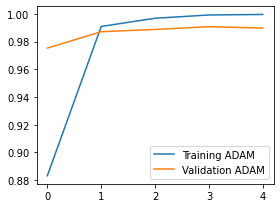

In [13]:
import matplotlib.pyplot as plt
model_history = pd.DataFrame(history.history)
model_history['epoch'] = history.epoch

fig, ax = plt.subplots(1, figsize=(4,3))
num_epochs = model_history.shape[0]

ax.plot(np.arange(0, num_epochs), model_history["accuracy"], 
        label="Training ADAM")
ax.plot(np.arange(0, num_epochs), model_history["val_accuracy"], 
        label="Validation ADAM")
ax.legend()

plt.tight_layout()
plt.show()

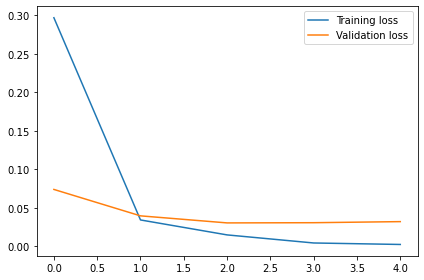

In [14]:
fig, ax = plt.subplots(1, figsize=(6,4))
num_epochs = model_history.shape[0]

ax.plot(np.arange(0, num_epochs), model_history["loss"], 
        label="Training loss")
ax.plot(np.arange(0, num_epochs), model_history["val_loss"], 
        label="Validation loss")
ax.legend()

plt.tight_layout()
plt.show()

In [15]:
accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))


96/96 [==============================] - 12s 128ms/step - loss: 0.0302 - accuracy: 0.9888
Test set
  Loss: 0.030
  Accuracy: 0.989


In [19]:
#txt = ["The speed and determination with which Europe initially acted startled even old hands in Brussels. Previous crises"]
txt=[" Football in Russia is crashing and isolation can only hasten its declineJonathan WilsonRussia’s pariah status spells disaster for its clubs and national team"]
seq = tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_len)
pred = model.predict(padded)
labels=["Art","Economy","Sports"]

print(pred, labels[np.argmax(pred)])

[[0.00325569 0.00114436 0.9956    ]] Sports
